In [1]:
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
# load and preprocess data
slice1 = sc.read_h5ad('E:/st_data/3D_rec/basic_usage_demo_1.h5ad')
slice2 = sc.read_h5ad('E:/st_data/3D_rec/basic_usage_demo_2.h5ad')

sc.pp.filter_cells(slice1, min_genes=10)
sc.pp.filter_genes(slice1, min_cells=3)
slice1.layers['counts'] = slice1.X.copy()
sc.pp.normalize_total(slice1)
sc.pp.log1p(slice1)
sc.pp.highly_variable_genes(slice1, n_top_genes=2000)

sc.pp.filter_cells(slice2, min_genes=10)
sc.pp.filter_genes(slice2, min_cells=3)
slice2.layers['counts'] = slice2.X.copy()
sc.pp.normalize_total(slice2)
sc.pp.log1p(slice2)
sc.pp.highly_variable_genes(slice2, n_top_genes=2000)

slice1.var_names_make_unique()
slice2.var_names_make_unique()

section_ids = ['slice1', 'slice2']
slice1.obs['batch'] = section_ids[0]
slice2.obs['batch'] = section_ids[1]

Training on cuda, please wait...


Epoch: 199, Loss: -435.483 step time=0.211s: 100%|██████████| 200/200 [00:42<00:00,  4.76it/s]


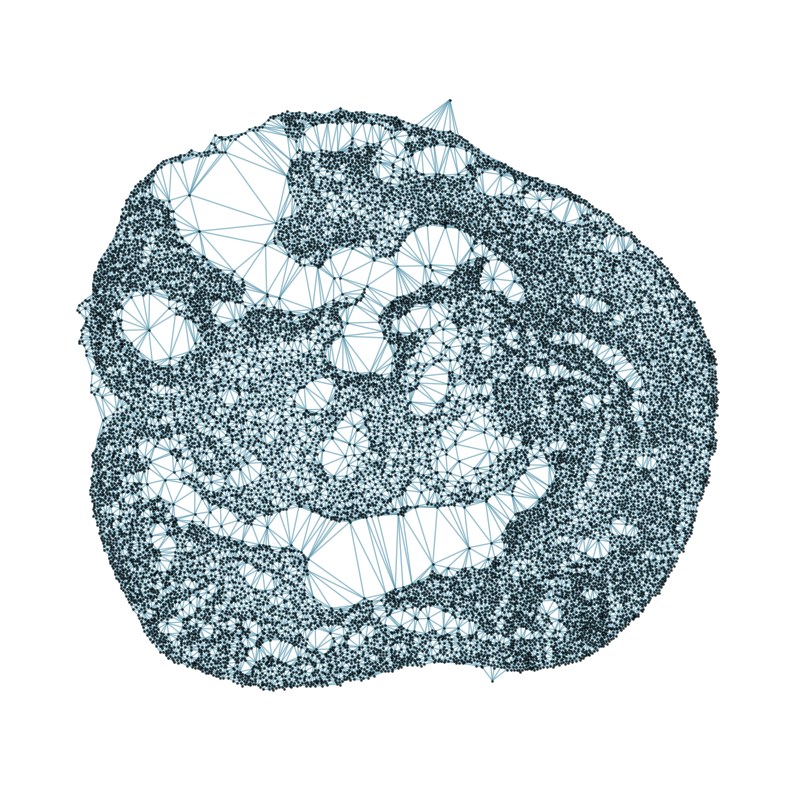

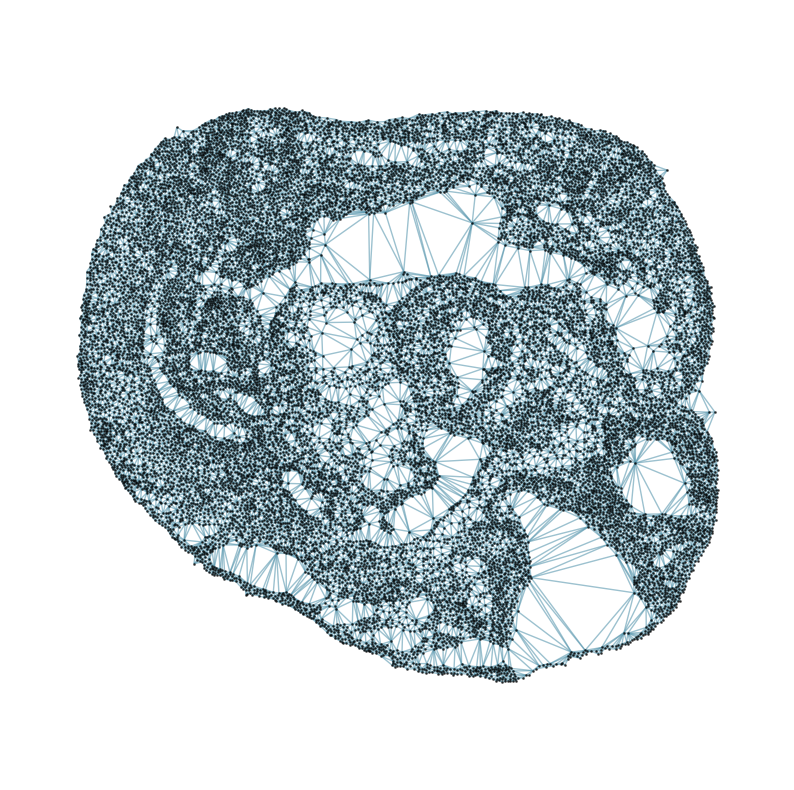

In [3]:
from GEASO.utils.utils import intersect, feature_extract

common_genes = intersect(slice1.var_names, slice2.var_names)
slice1 = slice1[:, common_genes]
slice2 = slice2[:, common_genes]

adata_list = [slice1, slice2]
emb_dict, loss_log, model = feature_extract(adata_list)
torch.cuda.empty_cache()

In [4]:
slice1.obsm['latent'] = emb_dict[section_ids[0]].cpu().numpy()
slice2.obsm['latent'] = emb_dict[section_ids[1]].cpu().numpy()

## Perform alignment of the two slices (Rigid -> Non-rigid)

In [5]:
from GEASO.alignment.coarse_alignment import coarse_alignment

R, t, scale, P, spatial_scales, spatial_means, guided_source, guided_target, coarse_source, coarse_target = coarse_alignment(source=slice1, target=slice2, top_K=10, dis_metric='cos', use_latent=True, scale_c=False)

[1389.42292714 1389.42292714] [[ 4967.60798723 10278.4709249 ]
 [15312.41594985 10399.64207961]]


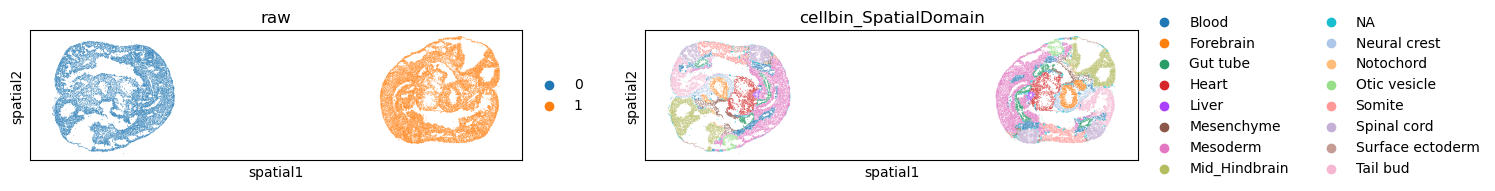

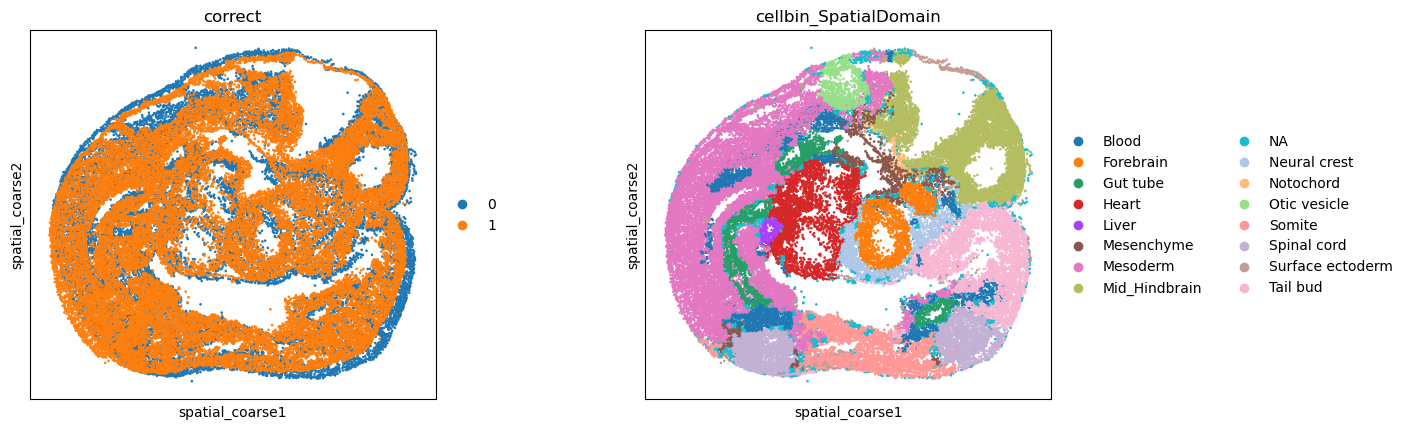

In [6]:
import anndata as ad

slice1.obsm['spatial_coarse'] = coarse_source.copy()
slice2.obsm['spatial_coarse'] = coarse_target.copy()

adata_cat = ad.concat([slice1, slice2], label='batch')
sc.pl.spatial(adata_cat, color=['batch', 'cellbin_SpatialDomain'], spot_size=20, title='raw')
sc.pl.spatial(adata_cat, basis='spatial_coarse', color=['batch', 'cellbin_SpatialDomain'], spot_size=0.02, title='correct')

In [7]:
from GEASO.alignment.elastic_registration import ElasticRegistration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
register_model = ElasticRegistration(
    init_P=P,
    guided_source=guided_source,
    guided_target=guided_target,
    source_slice=slice1,
    target_slice=slice2,
    normalize_scales=spatial_scales,
    normalize_means=spatial_means,
    spatial_key='spatial_coarse',
    device=device,
)

Local structure kernel constructed with shape: torch.Size([17425, 100])


Slice Alignment: 100%|██████████| 200/200 [00:03<00:00, 52.59it/s]


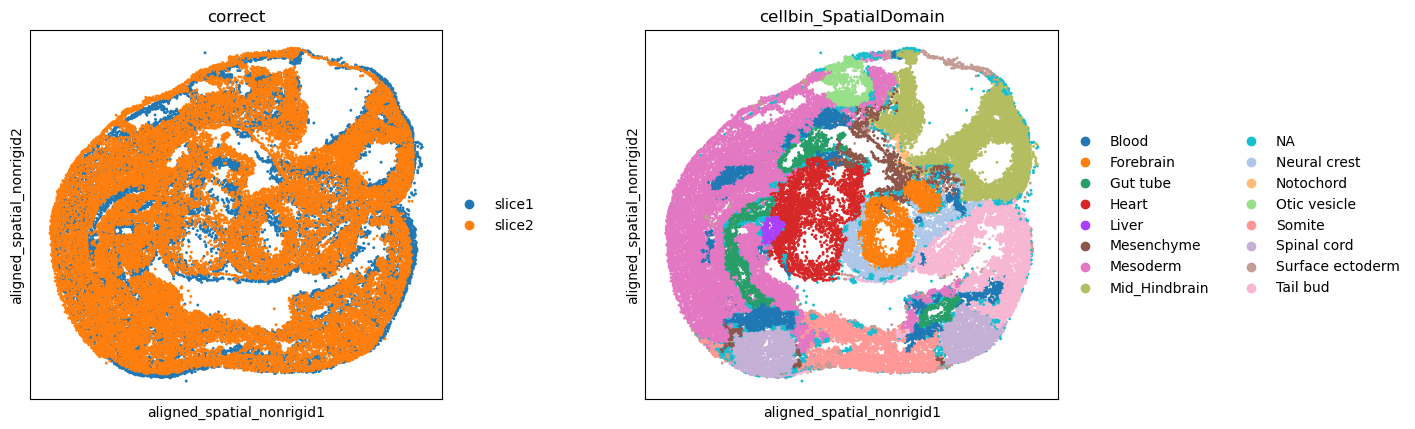

In [8]:
import anndata as ad

slice2.obsm['aligned_spatial_nonrigid'] = slice2.obsm['spatial'].copy()
adata_cat = ad.concat([slice1, slice2], label='batch', keys=['slice1', 'slice2'])
sc.pl.spatial(adata_cat, basis='aligned_spatial_nonrigid', color=['batch', 'cellbin_SpatialDomain'], spot_size=30, title='correct')